In [1]:

import os
import keras
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, Input, MaxPooling2D, MaxPooling1D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#from google.colab import drive
from datetime import datetime  # for collecting train times
import visualkeras  # for visualizing the NN models


In [2]:
#drive.mount('/content/drive')

In [3]:
train_path = "guitarchordsv3_archive/Training" # assuming this notebook is in the same directory as guitarchordsv3_archive
test_path = "guitarchordsv3_archive/Test"

sr = 16000  # sampling rate
n_mfcc = 80  # No. of mfcc features
N_CLASSES = 8  # No. of classes

In [4]:
def extract_mfcc(file, sr):
    audio, sr = librosa.load(file, sr=sr)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [5]:
def extract_spectrogram(file, sr, minlength):
    audio, sr = librosa.load(file, sr=sr)
    # Compute the spectrogram. n_mels is frequency step size, fmax is maximum frequency
    n_mels=128
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
    # Convert the spectrogram to decibel scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    #could use np.abs on the spectrogram
    
    # Need to pad or chop wav files. Only take first minlength of values, or pad with zeros until minlength is reached.
    spectrogram_db = spectrogram_db[:,:minlength] # python index slicing all rows with only minlength of columns
    d1, d2 = spectrogram_db.shape #extract the length of columns
    padding = np.zeros((n_mels, np.abs(minlength - d2))) # Create a 2D NumPy zeros array with rows=n_mels, for concat to work
    spectrogram_db_padded = np.concatenate((padding,spectrogram_db), axis=1) # concat columns axis only. Front padding first.
    # CNN expects single channel dimension (gray scale)
    spectrogram_db_dim = np.expand_dims(spectrogram_db_padded,axis=2)
    return spectrogram_db_dim

In [6]:
def get_data(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes
    le = LabelEncoder()
    le.fit(classes)

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)

    N = len(wav_paths)
    X = np.empty((N, n_mfcc), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_mfcc(wav_file, sr)
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES)
    print(classes)
    print(labels)

    return X, Y

In [7]:
def get_data_spectrograms(folder_path):
    wav_paths = glob(f"{folder_path}/**", recursive=True)  # this list includes folder_path, all subfolder paths and all file paths inside subfolder paths.
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x] # list of all audio file paths with '\\' replaced with '/'

    classes = sorted(os.listdir(folder_path))  # make a list of classes/chords
    le = LabelEncoder()
    le.fit(classes) # give label encoder the list of chords to classify

    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]  # remove audio file name and split using '/' to get label at the end
    labels = le.transform(labels)  # remaps chord names to integer values
    # labels array now has integer value (chord label) for each corresponding 1440 wav files
    
    # Need to pad or chop wav files. Only take first 48000 samples, or about first 3 seconds of wav audio
    N = len(wav_paths)  # length of wav_paths and labels should be exactly the same
    minHeight = 128 # height of input, also same as n_mels, which is frequency step size
    minLength = 200 # length of input
    X = np.empty((N, minHeight, minLength, 1), dtype=np.float32)  # create empty array to store audio samples later
    Y = np.empty((N, N_CLASSES), dtype=np.float32)

    for i, (wav_file, label) in enumerate(zip(wav_paths, labels)):
        X[i, :] = extract_spectrogram(wav_file, sr, minLength) #samplerate=16000
        Y[i, :] = to_categorical(label, num_classes=N_CLASSES) # one hot encoding. Converts a list of integers to binary flag with num_classes length.
    print(classes)
    print(labels)
    

    return X, Y

<h1>Define the three models</h1>

In [8]:
def model_dense():
    model = Sequential()
    model.add(Input(shape=(80,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model1 = model_dense()
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,528 (99.72 KB)

 Trainable params: 25,528 (99.72 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def model_conv2d():
    model = Sequential()
    model.add(Input(shape=(128, 200, 1)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid"))
    
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1), padding="valid"))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

model2 = model_conv2d()
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 125, 197, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 123, 195, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 123, 195, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 383760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │      12,280,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,285,560 (46.87 MB)

 Trainable params: 12,285,560 (46.87 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def model_conv1d_spectrogram():
    model = Sequential()
    model.add(Input(shape=(128*200, 1))) # 128*200 or 80 
    model.add(Conv1D(32, kernel_size=7, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

model3 = model_conv1d_spectrogram()
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 25594, 32)           │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25594, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 25592, 16)           │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 12796, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 204736)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │       6,551,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,553,656 (25.00 MB)

 Trainable params: 6,553,656 (25.00 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def model_conv1d_mfcc():
    model = Sequential()
    model.add(Input(shape=(80, 1))) # 128*200 or 80 
    model.add(Conv1D(32, kernel_size=7, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()

    return model

model4 = model_conv1d_mfcc()
model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 74, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 74, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 72, 16)              │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 36, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,536 (80.22 KB)

 Trainable params: 20,536 (80.22 KB)

 Non-trainable params: 0 (0.00 B)

<h1>Visualize the CNN models</h1>

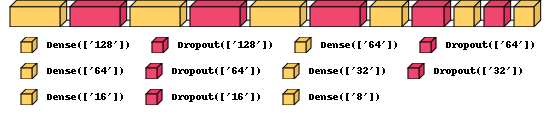

In [31]:
 # display using your system viewer
visualkeras.layered_view(model1, legend=True, show_dimension=True, scale_xy=1, scale_z=1, max_z=50)
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

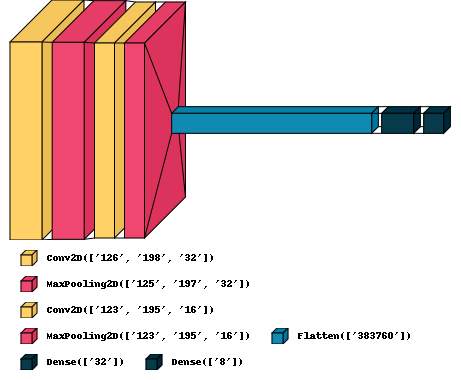

In [20]:
visualkeras.layered_view(model2, legend=True, show_dimension=True, scale_xy=1, scale_z=1, max_z=200)
#visualkeras.layered_view(model2, legend=True).show()

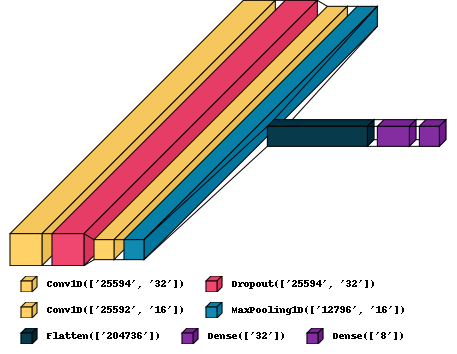

In [45]:
visualkeras.layered_view(model3, legend=True, show_dimension=True, scale_xy=1, max_xy=700, scale_z=1, max_z=100)
#visualkeras.layered_view(model2, legend=True).show()

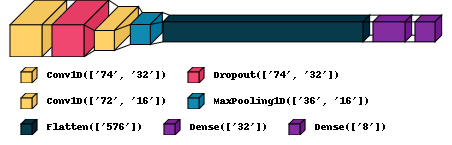

In [56]:
visualkeras.layered_view(model4, legend=True, show_dimension=True, scale_xy=1, scale_z=1, max_z=200)
#visualkeras.layered_view(model2, legend=True).show()

 <h1>Train the ANN model using the dense architecture</h1>

In [20]:
X, Y = get_data(train_path)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 80)
Shape of Y: (1440, 8)


In [21]:
start_time = datetime.now()

epochs = 100
batch_size = 16
history1 = model1.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1314 - loss: 12.8122
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.1502 - loss: 2.6524
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1279 - loss: 2.3752  
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.1736 - loss: 2.1444
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1863 - loss: 2.0882
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1661 - loss: 2.1065  
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2050 - loss: 2.0146
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2133 - loss: 2.0224  
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2376 - loss: 1.9025  
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.2108 - loss: 1.9281
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2481 - loss: 1.8377
Epoch 12/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

<h1>Train the 2-D CNN using 2-D spectrograms</h1>

In [22]:
x_train, y_train = get_data_spectrograms(train_path)
print(f"Shape of X: {x_train.shape}")
print(f"Shape of Y: {y_train.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 128, 200, 1)
Shape of Y: (1440, 8)


In [23]:
start_time = datetime.now()

epochs = 3
batch_size = 16
history2 = model2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 1.0000 - loss: 1.4398e-04
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 1.0000 - loss: 9.2459e-05
Duration: 0:00:43.069220


<h1>Train the 1-D CNN with flattened spectrograms</h1>

In [24]:
#x_train, y_train = get_data_spectrograms(train_path)
sample_size = x_train.shape[0] # number of samples in train set
y_axis = x_train.shape[1] # number of n_mels in train set
x_axis = x_train.shape[2] # minLength = 200 # length of input
channel_dimension = 1     # color channel is represented by 1 number

x_train_reshaped = x_train.reshape(sample_size, y_axis*x_axis, channel_dimension)

print(f"Shape of X: {x_train_reshaped.shape}")
print(f"Shape of Y: {x_train_reshaped.shape}")

Shape of X: (1440, 25600, 1)
Shape of Y: (1440, 25600, 1)


<h2>Using spectrogram flattened into (128*200, 1)</h2>

In [25]:
start_time = datetime.now()

epochs = 10 # not very good and takes long time to train, eventually converges around 15% accuracy
batch_size = 16
history3 = model3.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1225 - loss: 2.0338
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.1607 - loss: 2.0135
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.1500 - loss: 2.0051
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1387 - loss: 2.0158
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.1593 - loss: 2.0034
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.1466 - loss: 2.0230
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.1464 - loss: 2.0210
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.1619 - loss: 2.0310
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1562 - loss: 2.0124
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1449 - loss: 2.0194
Duration: 0:02:05.781142


<h1>Train the 1-D CNN with mfcc spectrogram</h1>

<h2>Using mfcc flattened into (80, 1)</h2>

In [26]:
X, Y = get_data(train_path)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 ... 7 7 7]
Shape of X: (1440, 80)
Shape of Y: (1440, 8)


In [27]:
start_time = datetime.now()

epochs = 10
batch_size = 16
history4 = model4.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4303 - loss: 2.4298
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9511 - loss: 0.1749
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0701
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0454
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0395
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0264
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0189
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0486
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0132
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0159
Duration: 0:00:02.778163


<h1>Display the plots for loss and accuracy for each of the models</h1>

In [28]:
history_dict1 = history1.history
loss_list1 = history_dict1['loss']
accuracy_list1 = history_dict1['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list1), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list1)*100, decimals=2)}%")

Minimum Loss = 0.04
Maximum Accuracy = 99.17%


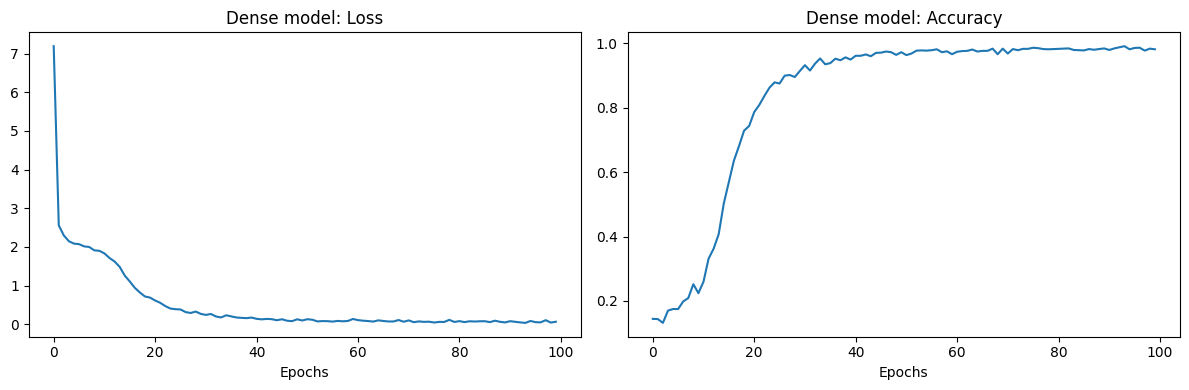

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(100), loss_list1) # epochs=100
plt.title("Dense model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(100), accuracy_list1)
plt.title("Dense model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [31]:
history_dict2 = history2.history
loss_list2 = history_dict2['loss']
accuracy_list2 = history_dict2['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list2), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list2)*100, decimals=2)}%")

Minimum Loss = 0.0
Maximum Accuracy = 100.0%


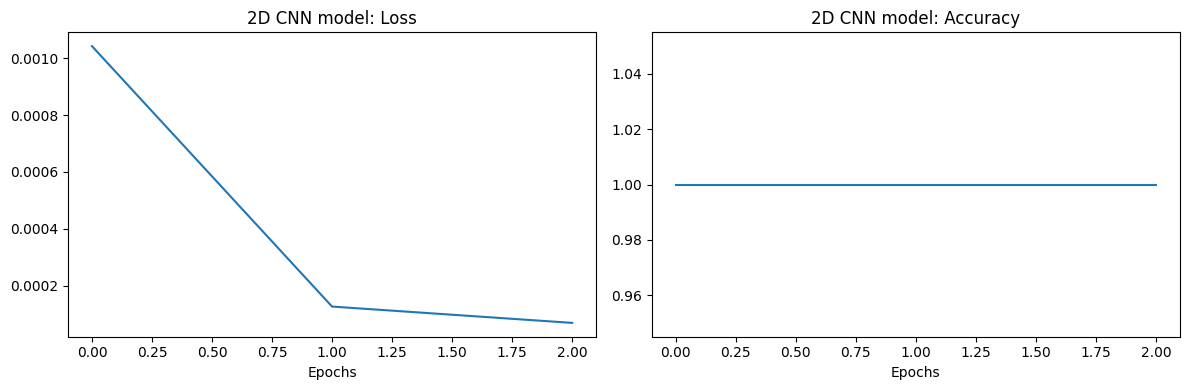

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(3), loss_list2) #epochs=3
plt.title("2D CNN model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(3), accuracy_list2) #epochs=10
plt.title("2D CNN model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [33]:
history_dict3 = history3.history
loss_list3 = history_dict3['loss']
accuracy_list3 = history_dict3['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list3), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list3)*100, decimals=2)}%")

Minimum Loss = 2.0
Maximum Accuracy = 15.62%


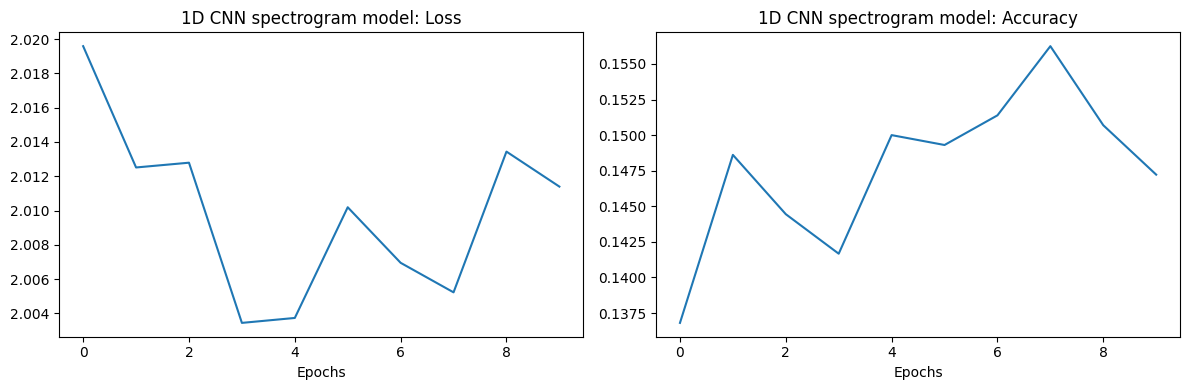

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(10), loss_list3) #epochs=10
plt.title("1D CNN spectrogram model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(10), accuracy_list3) #epochs=10
plt.title("1D CNN spectrogram model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [35]:
history_dict4 = history4.history
loss_list4 = history_dict4['loss']
accuracy_list4 = history_dict4['accuracy']
print(f"Minimum Loss = {np.round(np.min(loss_list4), decimals=2)}")
print(f"Maximum Accuracy = {np.round(np.max(accuracy_list4)*100, decimals=2)}%")

Minimum Loss = 0.02
Maximum Accuracy = 99.51%


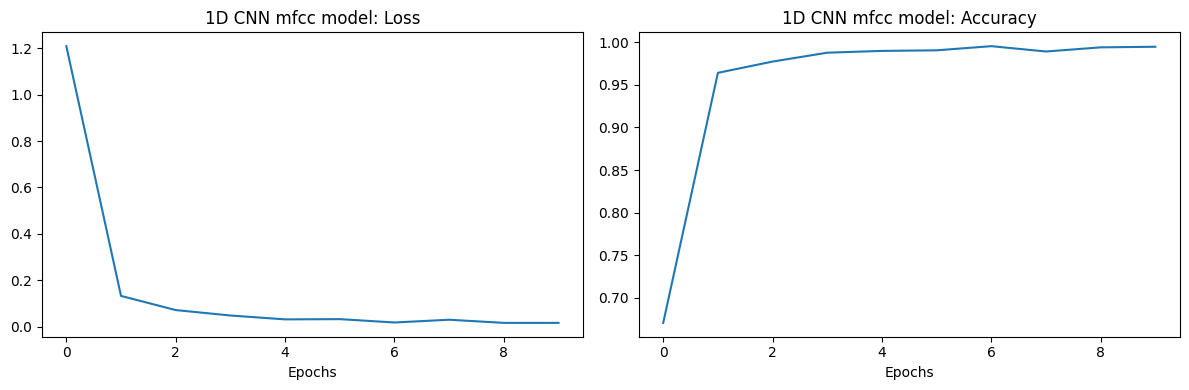

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), loss_list4) #epochs=10
plt.title("1D CNN mfcc model: Loss")
plt.xlabel("Epochs")
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), accuracy_list4) #epochs=10
plt.title("1D CNN mfcc model: Accuracy")
plt.xlabel("Epochs")
plt.tight_layout()

In [38]:
# Save the trained models
model1.save('models/ann.h5')# Change the path if needed

In [39]:
model2.save('models/cnn2dspectrogram.h5')  # Change the path if needed

In [40]:
model3.save('models/cnn1dspectrogram.h5')

In [41]:
model4.save('models/cnn1dmfcc.h5')

<h1>Load the saved ANN model from file and evaluate</h1>

In [42]:
load_model1 = load_model('models/ann.h5')

In [43]:
X_test, Y_test = get_data(test_path)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Shape of X_test: (320, 80)
Shape of Y_test: (320, 8)


In [44]:
# Assuming you have test data (X_test, Y_test)
loss, accuracy = load_model1.evaluate(X_test, Y_test, verbose=2)
print('Test Accuracy:', accuracy)

10/10 - 0s - 20ms/step - accuracy: 0.9750 - loss: 0.3000
Test Accuracy: 0.9750000238418579


In [59]:
N_test = 10
correct = 0
examples = []
for i in range(N_test-1):
    examples.append(np.expand_dims(X_test[i], axis=0)) # have to encapsulate in another np array

for i in range(N_test-1):
    tlabel = np.argmax(Y_test[i])
    # since last layer is softmax for multiclassification, use argmax to get most likely prediction
    mpred = np.argmax(load_model1.predict(examples[i]))
    if (tlabel == mpred):
        correct+=1
    print(f'True label: {tlabel}')
    print(f'Model prediction: {mpred}')
    
print(f'Accuracy: {correct/N_test}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
Accuracy: 0.9


<h1>Load the saved 2-D CNN model from file and evaluate</h1>

In [47]:
load_model2 = load_model('models/cnn2dspectrogram.h5')

In [48]:
x_test, y_test = get_data_spectrograms(test_path)
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Shape of x_test: (320, 128, 200, 1)
Shape of y_test: (320, 8)


In [49]:
# Assuming you have test data (x_test, y_test)
loss, accuracy = load_model2.evaluate(x_test, y_test, verbose=2)
print('Test Accuracy:', accuracy)

10/10 - 1s - 51ms/step - accuracy: 0.9688 - loss: 0.2756
Test Accuracy: 0.96875


In [50]:
N_test = 10
correct = 0
examples = []
for i in range(N_test-1):
    examples.append(np.expand_dims(x_test[i], axis=0)) # have to encapsulate in another np array

for i in range(N_test-1):
    tlabel = np.argmax(y_test[i])
    # since last layer is softmax for multiclassification, use argmax to get most likely prediction
    mpred = np.argmax(load_model2.predict(examples[i]))
    if (tlabel == mpred):
        correct+=1
    print(f'True label: {tlabel}')
    print(f'Model prediction: {mpred}')
    
print(f'Accuracy: {correct/N_test}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True label: 0
Model prediction: 0
Accuracy: 0.9


<h1>Load the saved 1-D CNN spectrogram model from file and evaluate</h1>

In [51]:
load_model3 = load_model('models/cnn1dspectrogram.h5')

In [52]:
x_test, y_test = get_data_spectrograms(test_path)
sample_size = x_test.shape[0] # number of samples in train set
y_axis = x_test.shape[1] # number of n_mels in train set
x_axis = x_test.shape[2] # minLength = 200 # length of input
channel_dimension = 1     # color channel is represented by 1 number

x_test_reshaped = x_test.reshape(sample_size, y_axis*x_axis, channel_dimension)

print(f"Shape of x_test_reshaped: {x_test_reshaped.shape}")
print(f"Shape of y_test: {y_test.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Shape of x_test_reshaped: (320, 25600, 1)
Shape of y_test: (320, 8)


In [53]:
# Assuming you have test data (x_test_reshaped, y_test)
loss, accuracy = load_model3.evaluate(x_test_reshaped, y_test, verbose=2)
print('Test Accuracy:', accuracy)

10/10 - 1s - 61ms/step - accuracy: 0.1906 - loss: 2.1710
Test Accuracy: 0.19062499701976776


In [54]:
N_test = 10
correct = 0
examples = []
for i in range(N_test-1):
    examples.append(np.expand_dims(x_test_reshaped[i], axis=0)) # have to encapsulate in another np array

for i in range(N_test-1):
    tlabel = np.argmax(y_test[i])
    # since last layer is softmax for multiclassification, use argmax to get most likely prediction
    mpred = np.argmax(load_model3.predict(examples[i]))
    if (tlabel == mpred):
        correct+=1
    print(f'True label: {tlabel}')
    print(f'Model prediction: {mpred}')
    
print(f'Accuracy: {correct/N_test}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True label: 0
Model prediction: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True label: 0
Model prediction: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True label: 0
Model prediction: 3
Accuracy: 0.0


<h1>Load the saved 1-D CNN mfcc model from file and evaluate</h1>

In [55]:
load_model4 = load_model('models/cnn1dmfcc.h5')

In [56]:
X_test, Y_test = get_data(test_path)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Shape of X_test: (320, 80)
Shape of Y_test: (320, 8)


In [57]:
# Assuming you have test data (X_test, Y_test)
loss, accuracy = load_model4.evaluate(X_test, Y_test, verbose=2)
print('Test Accuracy:', accuracy)

10/10 - 0s - 21ms/step - accuracy: 0.9781 - loss: 0.1662
Test Accuracy: 0.9781249761581421


In [60]:
N_test = 10
correct = 0
examples = []
for i in range(N_test-1):
    examples.append(np.expand_dims(X_test[i], axis=0)) # have to encapsulate in another np array

for i in range(N_test-1):
    tlabel = np.argmax(Y_test[i])
    # since last layer is softmax for multiclassification, use argmax to get most likely prediction
    mpred = np.argmax(load_model1.predict(examples[i]))
    if (tlabel == mpred):
        correct+=1
    print(f'True label: {tlabel}')
    print(f'Model prediction: {mpred}')
    
print(f'Accuracy: {correct/N_test}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
True label: 0
Model prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
True label: 0
Model prediction: 0
Accuracy: 0.9
